In [1]:
import pandas as pd, numpy as np, string, re, pytz
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from datetime import datetime as dt
%matplotlib inline

In [2]:
# define the fonts to use for plots
family = 'DejaVu Sans'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')
ticks_font_h = fm.FontProperties(family=family, style='normal', size=10.5, weight='normal', stretch='normal')

In [3]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    import matplotlib.cm as cm, numpy as np
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

In [4]:
artists_most = pd.read_csv('data/lastfm_top_artists.csv', encoding='utf-8')
artists_most = artists_most.set_index('artist')['play_count'].head(25)
artists_most.head()

artist
Opeth                               668
Between the Buried and Me           186
King Gizzard & The Lizard Wizard    165
Lucifer                             154
Gojira                              139
Name: play_count, dtype: int64

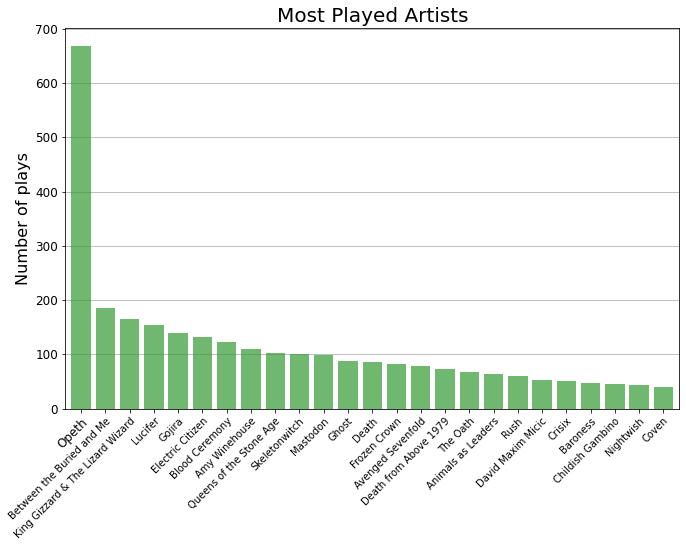

In [38]:
ax = artists_most.plot(kind='bar', figsize=[11, 7], width=0.8, alpha=0.7, color='#339933', edgecolor=None, zorder=2)

ax.yaxis.grid(True)
ax.set_xticklabels(artists_most.index, 
                   rotation=45, 
                   rotation_mode='anchor', 
                   ha='right', 
                   fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Most Played Artists', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

#plt.savefig('images/lastfm-artists-played-most.png', dpi=96, bbox_inches='tight')
plt.show()

In [7]:
tracks_most = pd.read_csv('data/lastfm_top_tracks.csv', encoding='utf-8')

def make_label(row, maxlength=30, suffix='...'):
    artist = row['artist']
    track = row['track']
    if len(track) > maxlength:
        track = '{}{}'.format(track[:maxlength-len(suffix)], suffix)
    return '{}\n{}'.format(artist, track)

index = tracks_most.apply(make_label, axis='columns')
tracks_most = tracks_most.set_index(index).drop(labels=['artist', 'track'], axis='columns')
tracks_most = tracks_most['play_count'].head(20)
tracks_most.head()

King Gizzard & The Lizard Wizard\nMars For The Rich    11
Lucifer\nBefore the Sun                                11
Opeth\nBleak                                           11
Opeth\nHarvest                                         11
Opeth\nThe Funeral Portrait                            11
Name: play_count, dtype: int64

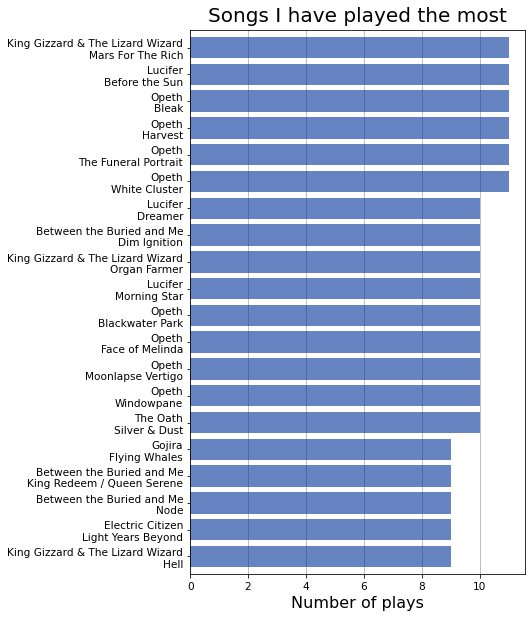

In [8]:
ax = tracks_most.sort_values().plot(kind='barh', figsize=[6, 10], width=0.8, alpha=0.6, 
                                    color='#003399', edgecolor=None, zorder=2)
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Songs I have played the most', fontproperties=title_font, y=1.005)

 # plt.savefig('images/lastfm-tracks-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

In [9]:
albums_most = pd.read_csv('data/lastfm_top_albums.csv', encoding='utf-8')

def make_label(row, maxlength=25, suffix='...'):
    artist = row['artist']
    track = row['album']
    if len(track) > maxlength:
        track = '{}{}'.format(track[:maxlength-len(suffix)], suffix)
    return '{}\n{}'.format(artist, track)

index = albums_most.apply(make_label, axis='columns')
albums_most = albums_most.set_index(index).drop(labels=['artist', 'album'], axis='columns')
albums_most = albums_most['play_count'].head(30)
albums_most.head()

Between the Buried and Me\nComa Ecliptic                   84
King Gizzard & The Lizard Wizard\nInfest the Rats' Nest    84
Opeth\nBlackwater Park                                     79
Gojira\nFrom Mars to Sirius                                76
Opeth\nHeritage (Special Edit...                           70
Name: play_count, dtype: int64

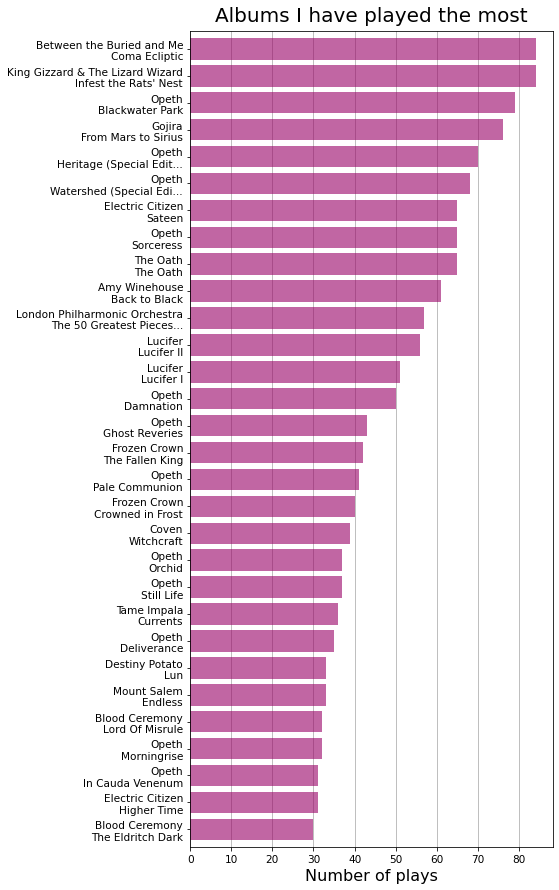

In [10]:
ax = albums_most.sort_values().plot(kind='barh', figsize=[6.5, 15], width=0.8, alpha=0.6, color='#990066', 
                                    edgecolor=None, zorder=2)
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Albums I have played the most', fontproperties=title_font, y=1.005)

 # plt.savefig('images/lastfm-albums-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

In [11]:
# read the all-time scrobbles data set
scrobbles = pd.read_csv('data/lastfm_scrobbles.csv', encoding='utf-8')
scrobbles = scrobbles.drop('timestamp', axis=1)
print('{:,} total scrobbles'.format(len(scrobbles)))
print('{:,} total artists'.format(len(scrobbles['artist'].unique())))

6,735 total scrobbles
705 total artists


In [12]:
# convert to datetime
scrobbles['timestamp'] = pd.to_datetime(scrobbles['datetime'])

In [13]:
# functions to convert UTC to <timezone> and extract date/time elements
convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('US/Central'))
get_year = lambda x: convert_tz(x).year
get_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month) #inefficient
get_day = lambda x: convert_tz(x).day
get_hour = lambda x: convert_tz(x).hour
get_day_of_week = lambda x: convert_tz(x).weekday()

In [14]:
# parse out date and time elements as pacific time
scrobbles['year'] = scrobbles['timestamp'].map(get_year)
scrobbles['month'] = scrobbles['timestamp'].map(get_month)
scrobbles['day'] = scrobbles['timestamp'].map(get_day)
scrobbles['hour'] = scrobbles['timestamp'].map(get_hour)
scrobbles['dow'] = scrobbles['timestamp'].map(get_day_of_week)
scrobbles = scrobbles.drop(labels=['datetime'], axis=1)

# drop rows with 01-01-1970 as timestamp
scrobbles = scrobbles[scrobbles['year'] > 1970]
scrobbles.head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
0,All That Remains,4f8b7186-b2a2-40db-97ae-6e1cd46d57b1,For We Are Many,00e40879-8672-45f6-9172-72b891a955d4,The Last Time,2fea6a59-f18c-3fc1-ae81-998bacc4731d,2021-01-30 01:22:56,2021,2021-01,29,19,4
1,Chimp Spanner,a9d72c8b-fea3-4927-9521-156e6fe05f37,All Roads Lead Here,5cdbd6b6-4644-4d5f-87a7-15809be88520,Engrams,0440be26-f1fb-3556-b375-912a4c665950,2021-01-30 01:20:29,2021,2021-01,29,19,4
2,Lady Gaga,650e7db6-b795-4eb5-a702-5ea2fc46c848,Chromatica,18b53118-01bb-4ed8-b21e-81f7b9c26464,Stupid Love,08845e2d-cfb7-4aaa-b529-532c9c38fa90,2021-01-29 05:54:56,2021,2021-01,28,23,3
3,Kyuss,ea0f2a37-7007-4217-a812-396227f5013a,Green Machine,9799ed6a-88b2-4d3e-9592-2cdb851172e6,Mondo Generator,30e03a93-6f7f-4c72-ba28-9f537d35dbbd,2021-01-29 01:23:44,2021,2021-01,28,19,3
4,Outrun The Sunlight,388cfcf7-a7a4-4a54-b47e-3fadf2475205,Terrapin,4a45d00e-8e0e-47c9-9eea-dc803b44c39c,"Where Every Word Spoken, Speaks",60e98521-a97a-4247-9cca-3a403404d505,2021-01-29 01:20:43,2021,2021-01,28,19,3


In [15]:
year_counts = scrobbles['year'].value_counts().sort_index()

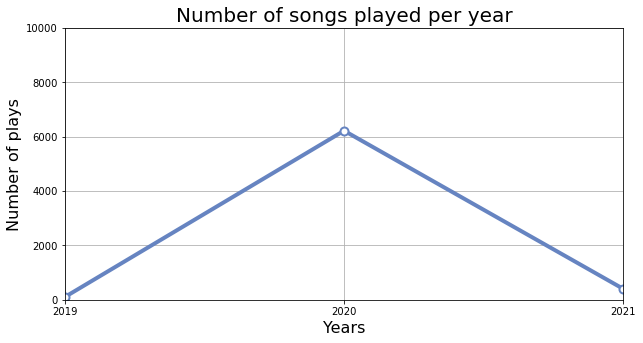

In [16]:
year_counts = scrobbles['year'].value_counts().sort_index()
ax = year_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.set_xlim((year_counts.index[0], year_counts.index[-1]))

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylim(0, 10000)
ax.set_xticks(year_counts.index)
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('Years', fontproperties=label_font)
ax.set_title('Number of songs played per year', fontproperties=title_font)

 # plt.savefig('images/lastfm-scrobbles-per-year.png', dpi=96, bbox_inches='tight')
plt.show()

In [17]:
# get all the scrobbles from 2010-present
min_year = 2019
scrobbles_10 = scrobbles[scrobbles['year'] >= min_year]
max_year = max(scrobbles_10['year'])

In [18]:
# count number of scrobbles in each month
month_counts = scrobbles_10['month'].value_counts().sort_index()

# not every month necessarily has a scrobble, so fill in missing months with zero counts
date_range = pd.date_range(start=min(scrobbles_10['timestamp']), end=max(scrobbles_10['timestamp']), freq='D')
months_range = date_range.map(lambda x: str(x.date())[:-3])
index = np.unique(months_range)
month_counts = month_counts.reindex(index, fill_value=0)

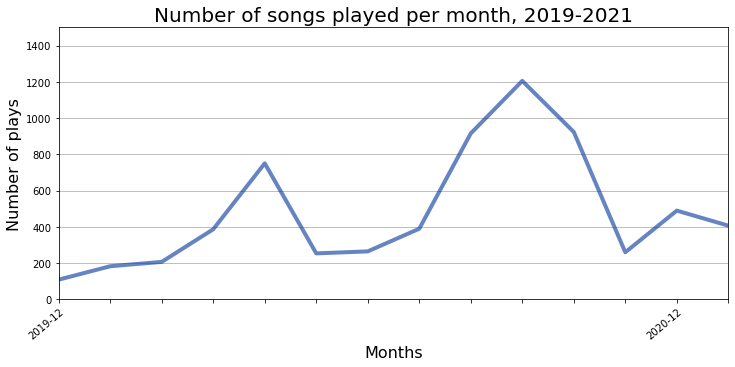

In [19]:
ax = month_counts.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=0.6, color='#003399')

xlabels = month_counts.iloc[range(0, len(month_counts), 12)].index
xlabels = [x if x in xlabels else '' for x in month_counts.index]
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right')

ax.set_xlim((0, len(month_counts)-1))

ax.yaxis.grid(True)
ax.set_ylim((0,1500))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('Months', fontproperties=label_font)
ax.set_title('Number of songs played per month, {}-{}'.format(min_year, max_year), fontproperties=title_font)

 # plt.savefig('images/lastfm-scrobbles-per-month.png', dpi=96, bbox_inches='tight')
plt.show()

In [20]:
# get the play count sum by day of the week
dow_counts = scrobbles['dow'].value_counts().sort_index()
dow_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

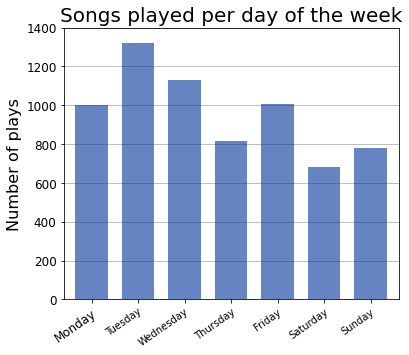

In [40]:

ax = dow_counts.plot(kind='bar', figsize=[6, 5], width=0.7, alpha=0.6, color='#003399', edgecolor=None, zorder=2)

ax.yaxis.grid(True)
ax.set_xticklabels(dow_counts.index, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_ylim((0, 1400))
ax.set_title('Songs played per day of the week', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

 # plt.savefig('images/lastfm-scrobbles-per-weekday.png', dpi=96, bbox_inches='tight')
plt.show()

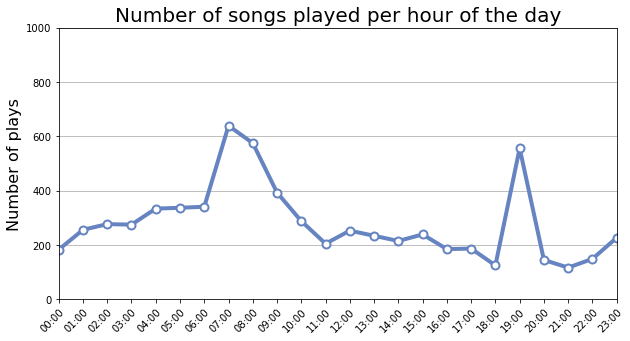

In [22]:
hour_counts = scrobbles['hour'].value_counts().sort_index()
ax = hour_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

xlabels = hour_counts.index.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((hour_counts.index[0], hour_counts.index[-1]))

ax.yaxis.grid(True)
ax.set_ylim((0, 1000))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per hour of the day', fontproperties=title_font)

 # plt.savefig('images/lastfm-scrobbles-per-hour.png', dpi=96, bbox_inches='tight')
plt.show()

In [23]:
# get the play counts by hour of day and day of week
weekday_hour_counts = scrobbles.groupby(['dow','hour']).count()['track']
hour_numbers = weekday_hour_counts.index.levels[1]
day_numbers = weekday_hour_counts.index.levels[0]
day_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

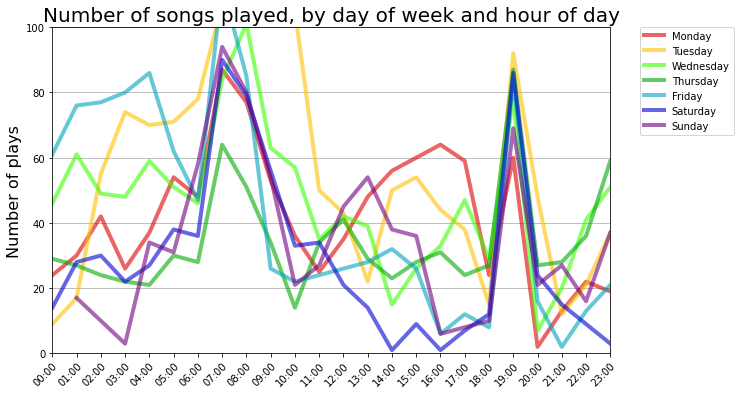

In [24]:
# get one color per day of week
colors = get_colors('nipy_spectral_r', n=len(day_numbers), start=0.1, stop=0.95)

fig, ax = plt.subplots(figsize=[10, 6])
lines = []
for day, c in zip(day_numbers, colors):
    ax = weekday_hour_counts[day].plot(kind='line', linewidth=4, alpha=0.6, c=c)
    lines.append(day_names[day])
    
xlabels = hour_numbers.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((hour_numbers[0], hour_numbers[-1]))

ax.yaxis.grid(True)
ax.set_ylim([0, 100])
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played, by day of week and hour of day', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.23,1.017))

 # plt.savefig('images/lastfm-scrobbles-days-hours.png', dpi=96, bbox_inches='tight')
plt.show()

In [25]:
#Add additional years to the 'isin' list to query multiple years.
scrobbles_year = scrobbles[scrobbles['year'].isin([2019,2020])]
len(scrobbles_year)

6329

In [26]:
# what artists did i play the most that year?
artists_year = scrobbles_year['artist'].value_counts()
artists_year = pd.DataFrame(artists_year).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_year.index = [n + 1 for n in artists_year.index]
artists_year.head(10)

,artist,play count
1,Opeth,583
2,Between the Buried and Me,180
3,King Gizzard & The Lizard Wizard,163
4,Lucifer,146
5,Gojira,130
6,Amy Winehouse,107
7,Electric Citizen,100
8,Skeletonwitch,97
9,Queens of the Stone Age,91
10,Mastodon,89


In [27]:
# what tracks did i play the most that year?
tracks_year = scrobbles_year.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_year = tracks_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_year.index = [n + 1 for n in tracks_year.index]
tracks_year.head(10)

,artist,track,play count
1,Lucifer,Before the Sun,11
2,King Gizzard & The Lizard Wizard,Mars For The Rich,11
3,Opeth,Windowpane,10
4,King Gizzard & The Lizard Wizard,Organ Farmer,10
5,Opeth,Bleak,10
6,Between the Buried and Me,Dim Ignition,10
7,King Gizzard & The Lizard Wizard,Perihelion,9
8,Between the Buried and Me,King Redeem / Queen Serene,9
9,Opeth,Face of Melinda,9
10,Gojira,Flying Whales,9


In [28]:
# what albums did i play the most that year?
albums_year = scrobbles_year.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_year = albums_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_year.index = [n + 1 for n in albums_year.index]

# remove text in parentheses or brackets
regex = re.compile('\\(.*\\)|\\[.*]')
albums_year['album'] = albums_year['album'].map(lambda x: regex.sub('', x))
albums_year.head(10)

,artist,album,play count
1,King Gizzard & The Lizard Wizard,Infest the Rats' Nest,84
2,Between the Buried and Me,Coma Ecliptic,83
3,Gojira,From Mars to Sirius,72
4,Opeth,Blackwater Park,67
5,Opeth,Sorceress,63
6,The Oath,The Oath,63
7,Amy Winehouse,Back to Black,60
8,Lucifer,Lucifer II,56
9,Opeth,Watershed,55
10,Opeth,Heritage,55


In [29]:
# Add additional months to the 'isin' list to query multiple months.
scrobbles_month = scrobbles[scrobbles['month'].isin(['2020-01'])]
len(scrobbles_month)

182

In [30]:
# what artists did i play the most that month?
artists_month = scrobbles_month['artist'].value_counts()
artists_month = pd.DataFrame(artists_month).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_month.index = [n + 1 for n in artists_month.index]
artists_month.head(10)

,artist,play count
1,Opeth,18
2,Mastodon,13
3,Rush,9
4,Avenged Sevenfold,4
5,Heart,4
6,Ghost,4
7,Ongkara,3
8,Snow Patrol,3
9,Between the Buried and Me,3
10,Gojira,3


In [41]:
# what tracks did i play the most that month?
tracks_month = scrobbles_month.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_month = tracks_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_month.index = [n + 1 for n in tracks_month.index]
tracks_month.head(12)

,artist,track,play count
1,Snow Patrol,Run,3
2,London Philharmonic Orchestra,Thaïs: Méditation,2
3,Behemoth,The Satanist,2
4,Cynic,The Eagle Nature,2
5,Slayer,Hell Awaits,2
6,Ramones,Rockaway Beach - 2017 Remaster,2
7,Judas Priest,Before the Dawn,2
8,TesseracT,Of Mind - Nocturne,2
9,Mastodon,Divinations,2
10,Heart,Barracuda,2


In [42]:
# what albums did i play the most that month?
albums_month = scrobbles_month.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_month = albums_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_month.index = [n + 1 for n in albums_month.index]
albums_month.head(12)

,artist,album,play count
1,Mastodon,Crack the Skye,9
2,Opeth,Blackwater Park,8
3,Opeth,Still Life,7
4,Rush,Moving Pictures (2011 Remaster),6
5,Avenged Sevenfold,Nightmare,3
6,London Philharmonic Orchestra,The 50 Greatest Pieces of Classical Music,2
7,Ongkara,Hopes & Corpses,2
8,Heart,Little Queen,2
9,Broken Bells,Broken Bells,2
10,Heart,Dreamboat Annie,2


In [33]:
# when were the last 5 times I played something by <artist>?
scrobbles[scrobbles['artist'].str.contains('Ongkara')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
159,Ongkara,e5d957f2-1d8f-4b26-af97-0c51dcb8e4ca,#взонериска,NaN,Родригез,NaN,2021-01-14 17:42:08,2021,2021-01,14,11,3
508,Ongkara,e5d957f2-1d8f-4b26-af97-0c51dcb8e4ca,Ongkara,cabd1dc0-7193-408a-a2e5-fe3c50888cc0,Monstriparity,a9b83f9c-e837-4140-86f9-c5c05311e232,2020-12-20 13:26:53,2020,2020-12,20,7,6
562,Ongkara,e5d957f2-1d8f-4b26-af97-0c51dcb8e4ca,Ongkara,cabd1dc0-7193-408a-a2e5-fe3c50888cc0,Poker,4b2e2764-bfcc-44c8-a602-6e29759a18af,2020-12-18 01:27:01,2020,2020-12,17,19,3
563,Ongkara,e5d957f2-1d8f-4b26-af97-0c51dcb8e4ca,Hopes & Corpses,58878483-ebf3-467c-a422-4cf04cd200a5,Fragile Empire,0c28c3fc-c01b-49e4-a197-91197a225652,2020-12-18 01:23:39,2020,2020-12,17,19,3
634,Ongkara,e5d957f2-1d8f-4b26-af97-0c51dcb8e4ca,Ongkara,cabd1dc0-7193-408a-a2e5-fe3c50888cc0,Adaptation,e0f54bbf-db43-4741-b2ec-226f4050f102,2020-12-15 05:57:40,2020,2020-12,14,23,0


In [34]:
# when were the last 5 times I played something off of <album>?
scrobbles[scrobbles['album'].fillna('').str.contains('Heritage')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
135,Opeth,c14b4180-dc87-481e-b17a-64e4150f90f6,Heritage (Special Edition),NaN,Face in the Snow,0a6278a6-3997-3b56-bd29-22eedb502eab,2021-01-15 20:34:33,2021,2021-01,15,14,4
136,Opeth,c14b4180-dc87-481e-b17a-64e4150f90f6,Heritage (Special Edition),NaN,Pyre,1ee772e2-569a-3b1d-9126-5eccbff99442,2021-01-15 20:29:00,2021,2021-01,15,14,4
137,Opeth,c14b4180-dc87-481e-b17a-64e4150f90f6,Heritage (Special Edition),NaN,Marrow of the Earth,027b20ed-703f-358c-a220-cfce0f69c2f1,2021-01-15 20:23:10,2021,2021-01,15,14,4
138,Opeth,c14b4180-dc87-481e-b17a-64e4150f90f6,Heritage (Special Edition),NaN,Folklore,227fd43c-b309-31ce-af62-4dcff984d6dc,2021-01-15 20:06:32,2021,2021-01,15,14,4
139,Opeth,c14b4180-dc87-481e-b17a-64e4150f90f6,Heritage (Special Edition),NaN,The Lines in My Hand,099b2903-8b08-3dc8-b2a4-448ffb7cd57b,2021-01-15 20:01:12,2021,2021-01,15,14,4


In [35]:
# when were the last 5 times I played <track>?
scrobbles[scrobbles['track'].str.contains('PLANET B')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow


In [36]:
# get the cumulative play counts since <year> for the top n most listened-to artists
n = 10
plays = scrobbles[scrobbles['artist'].isin(artists_most.head(n).index)]
plays = plays[plays['year'] >= 2019]
plays = plays.groupby(['artist','year']).count().groupby(level=[0]).cumsum()['track']

# make sure we have each year represented for each artist, even if they got no plays that year
plays = plays.unstack().T.fillna(method='ffill').T.stack()
top_artists = plays.index.levels[0]

<ipython-input-37-0f799f84c465>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plays.index.levels[1], rotation=0, rotation_mode='anchor', ha='center')


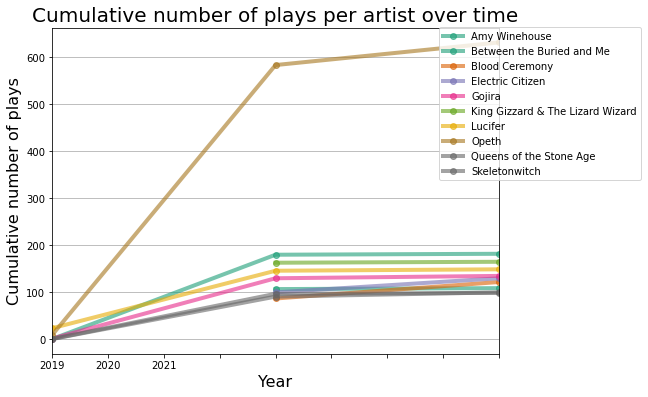

In [37]:
# get one color per artist
colors = get_colors('Dark2', n)

fig, ax = plt.subplots(figsize=[8, 6])
lines = []
for artist, c in zip(top_artists, colors):
    ax = plays[artist].plot(kind='line', linewidth=4, alpha=0.6, marker='o', c=c)
    lines.append(artist)
    
ax.set_xlim((plays.index.get_level_values(1).min(), plays.index.get_level_values(1).max()))

ax.yaxis.grid(True)
ax.set_xticklabels(plays.index.levels[1], rotation=0, rotation_mode='anchor', ha='center')
ax.set_ylabel('Cumulative number of plays', fontproperties=label_font)
ax.set_xlabel('Year', fontproperties=label_font)
ax.set_title('Cumulative number of plays per artist over time', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.33, 1.016))

 # plt.savefig('images/lastfm-scrobbles-top-artists-years.png', dpi=96, bbox_inches='tight')
plt.show()